In [ ]:
!pip install alpha_vantage pandas numpy matplotlib yfinance newsapi-python textblob quandl tweepy fredapi xgboost


In [ ]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from textblob import TextBlob
from newsapi import NewsApiClient
import requests
import tweepy
from fredapi import Fred
import json

# Initialize API clients
newsapi = NewsApiClient(api_key='b7e99c51eaf3492e81ef8d2f206cbb86')

# FIX: Ensure you have a valid FRED API key
FRED_API_KEY = "50113643558d6e3a373925ec8d3f9b57"
fred = Fred(api_key=FRED_API_KEY)

# Initialize Tweepy API for Twitter sentiment analysis
twitter_auth = tweepy.OAuthHandler('WOR1qlYILo9F2n5EKVJ1KTmVV', 'pHJUMNkryr0bIRAPPxcof0MM7YVaVuF93bTOIBNJbibZKxW9uw')
twitter_auth.set_access_token('1011195364496560128-HZLi5t3gSMdeg5osTtXG5YuvNhOXzx', 'gmGKlXmZUdQKC1olklaaRHaAyg5jzfpcOOJr7LoJ83fSZ')
twitter_api = tweepy.API(twitter_auth, wait_on_rate_limit=True)

# Alpha Vantage API Key (For corporate events)
ALPHA_VANTAGE_API_KEY = "H563VHZ8Z20EAU8U"

# Function to flatten DataFrame columns
def flatten_columns(df):
    """Flatten MultiIndex columns and rename 'Date_' to 'Date'."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]

    if 'Date_' in df.columns:
        df.rename(columns={'Date_': 'Date'}, inplace=True)

# Fetch Market Indices (S&P 500, DJIA, NASDAQ)
def fetch_index_data(symbols, start_date, end_date):
    """Fetches multiple market index data from Yahoo Finance."""
    index_data = yf.download(symbols, start=start_date, end=end_date, group_by='ticker')
    index_data = index_data.stack(level=0, future_stack=True).rename_axis(['Date', 'Ticker']).reset_index()  # FIXED FutureWarning
    flatten_columns(index_data)
    return index_data[['Date', 'Ticker', 'Close']]

# Fetch Stock Data
def fetch_stock_data(symbol, start_date, end_date):
    """Fetches stock data from Yahoo Finance and computes indicators."""
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    flatten_columns(stock_data)

    if 'Close' in stock_data.columns:
        stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
        stock_data['EMA_20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()
        stock_data['MACD'] = stock_data['Close'].ewm(span=12, adjust=False).mean() - stock_data['Close'].ewm(span=26, adjust=False).mean()
        stock_data['OBV'] = (np.sign(stock_data['Close'].diff()) * stock_data['Volume']).cumsum()
        stock_data['VWAP'] = (stock_data['Close'] * stock_data['Volume']).cumsum() / stock_data['Volume'].cumsum()

    return stock_data

# Fetch Economic Indicators (Including Unemployment Rate)
# Fetch Economic Indicators (Including Unemployment Rate)
def fetch_fred_data(series_ids, start_date, end_date):
    """Fetch multiple economic data series from FRED and rename columns uniquely."""
    dfs = []
    for series_id in series_ids:
        try:
            data = fred.get_series(series_id, start_date, end_date)
            df = pd.DataFrame({'Date': data.index, f"{series_id}_Value": data.values})  # Rename column uniquely
            df['Date'] = pd.to_datetime(df['Date'])
            dfs.append(df)
        except Exception as e:
            print(f" Failed to fetch {series_id} from FRED: {e}")

    if dfs:
        result_df = pd.concat(dfs, axis=1)
        result_df = result_df.loc[:, ~result_df.columns.duplicated()]  # Remove duplicate columns
        return result_df
    else:
        return pd.DataFrame()


# Merge Data
# Merge Data with Duplicate Handling
def merge_data(stock_data, index_data, economic_data):
    """Merges stock data with index & economic data while preventing duplicate column names."""
    if economic_data.empty:
        print(" Economic Data is missing, skipping merge.")
        return stock_data  # Proceed with available data

    for df in [stock_data, index_data, economic_data]:
        df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date column is in datetime format

    # Merge with suffixes to avoid duplicate columns
    merged_data = stock_data.merge(index_data, on=['Date'], how='left', suffixes=('', '_Index'))
    merged_data = merged_data.merge(economic_data, on=['Date'], how='left', suffixes=('', '_Econ'))

    # Drop any remaining duplicate columns
    merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

    return merged_data


# Process and Save Data
def process_tickers(tickers, start_date, end_date, output_dir):
    """Processes each ticker: fetches data, computes indicators, merges, and saves."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    index_data = fetch_index_data(['^GSPC', '^DJI', '^IXIC'], start_date, end_date)
    economic_data = fetch_fred_data(['DGS10', 'GDP', 'CPIAUCSL', 'UNRATE'], start_date, end_date)

    for ticker in tickers:
        print(f"Processing {ticker}")
        stock_data = fetch_stock_data(ticker, start_date, end_date)
        flatten_columns(stock_data)

        if not stock_data.empty:
            merged_data = merge_data(stock_data, index_data, economic_data)
            if not merged_data.empty:
                file_path = os.path.join(output_dir, f'{ticker}_financial_data.csv')
                merged_data.to_csv(file_path, index=False)
                print(f"Saved data for {ticker} to {file_path}")
            else:
                print(f" Skipping {ticker} due to incomplete data.")

if __name__ == "__main__":
    tickers = ['AAPL', 'MSFT', 'GOOGL']
    start_date = '2022-01-01'
    end_date = '2023-01-01'
    output_dir = './output'
    process_tickers(tickers, start_date, end_date, output_dir)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


🔄 Processing AAPL


[*********************100%***********************]  1 of 1 completed


✅ Saved data for AAPL to ./output/AAPL_financial_data.csv
🔄 Processing MSFT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Saved data for MSFT to ./output/MSFT_financial_data.csv
🔄 Processing GOOGL
✅ Saved data for GOOGL to ./output/GOOGL_financial_data.csv


In [ ]:
import pandas as pd
import os

def load_and_combine_data(tickers, output_dir):
    """Loads data for each ticker and combines into a single DataFrame using advanced merging strategies."""
    data_frames = []
    for ticker in tickers:
        file_path = os.path.join(output_dir, f'{ticker}_financial_data.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['Ticker'] = ticker  # Add ticker identifier to the data
            df['Date'] = pd.to_datetime(df['Date'])
            data_frames.append(df)
        else:
            print(f"File for {ticker} not found in {output_dir}")

    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame()  # Return empty DataFrame if no data was loaded

def clean_data(df):
    """Cleans the combined dataframe by handling missing values and standardizing formats."""
    df.sort_values(by=['Date', 'Ticker'], inplace=True)
    # More sophisticated fill methods might be added here
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

def check_data_quality(df):
    """Checks for common data quality issues."""
    if df.isnull().any().any():
        print("Warning: There are still missing values in the data.")
    if df.duplicated().any():
        print("Warning: There are duplicated entries in the data.")

# Set the directory where your files are saved
output_dir = './output'
tickers = ['AAPL', 'MSFT', 'GOOGL']

# Load and combine data from the specified tickers
combined_data = load_and_combine_data(tickers, output_dir)

# Clean the combined data
cleaned_data = clean_data(combined_data)

# Data quality check
check_data_quality(cleaned_data)

# Optionally, save the cleaned data to a new file
cleaned_data.to_csv(os.path.join(output_dir, 'combined_cleaned_data.csv'), index=False)

print("Data loading, combining, and cleaning complete. Cleaned data saved to 'combined_cleaned_data.csv'.")


Data loading, combining, and cleaning complete. Cleaned data saved to 'combined_cleaned_data.csv'.


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming the combined and cleaned data file is saved as 'combined_cleaned_data.csv' in the 'output' directory
file_path = './output/combined_cleaned_data.csv'

# Load the cleaned data
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature Engineering
# Lagged Variables for stock prices
lags = [1, 3, 7]  # Example lags for 1 day, 3 days, and 7 days
for lag in lags:
    for column in ['Close_AAPL', 'Close_MSFT', 'Close_GOOGL']:
        data[f'{column}_lag{lag}'] = data[column].shift(lag)

# Rolling Statistics for capturing trends and volatility
rolling_windows = [7, 14, 30]  # 1 week, 2 weeks, and 1 month windows
for window in rolling_windows:
    for column in ['Close_AAPL', 'Close_MSFT', 'Close_GOOGL']:
        data[f'{column}_rolling_mean_{window}'] = data[column].rolling(window=window).mean()
        data[f'{column}_rolling_std_{window}'] = data[column].rolling(window=window).std()

# Interaction Terms between stock prices and economic indicators
economic_indicators = ['DGS10_Value', 'GDP_Value', 'CPIAUCSL_Value']  # Example economic indicators
for stock in ['Close_AAPL', 'Close_MSFT', 'Close_GOOGL']:
    for econ in economic_indicators:
        data[f'{stock}_x_{econ}'] = data[stock] * data[econ]

# Data Transformation: Normalize or Scale Data for Neural Network readiness
scaler = MinMaxScaler()
numerical_cols = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Save the engineered data to a new CSV file for further analysis or modeling
data.to_csv('./output/data_with_features.csv')

print("Feature engineering complete. Engineered data saved to 'data_with_features.csv'.")


Feature engineering complete. Engineered data saved to 'data_with_features.csv'.


📊 Model Performance on Validation Set:
MAE: 0.0222, MSE: 0.0009, RMSE: 0.0296, R²: 0.9149

📊 Model Performance on Test Set:
MAE: 0.0241, MSE: 0.0013, RMSE: 0.0359, R²: 0.9293
✅ Model training complete. Saved trained model to 'random_forest_stock_model.pkl'.


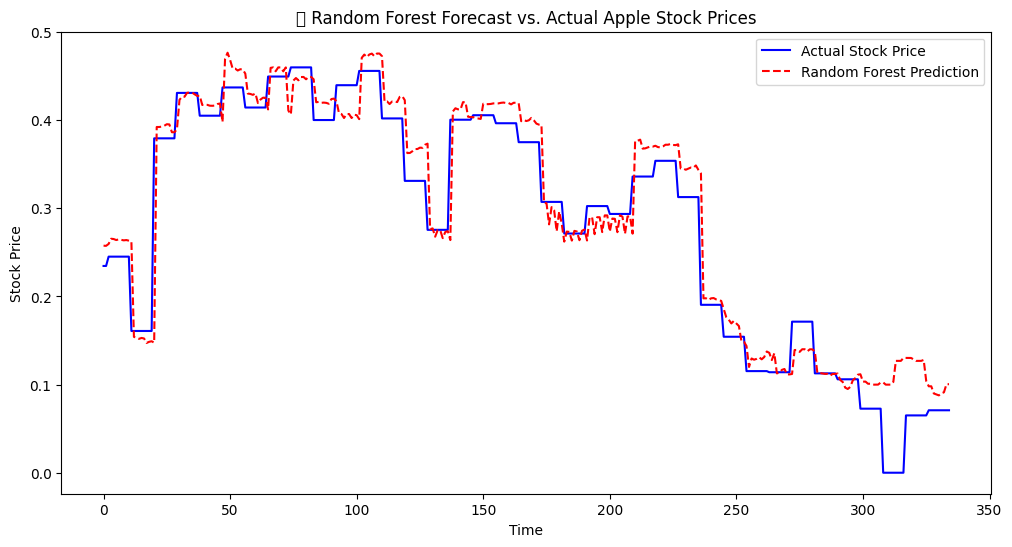

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

# Load the feature-engineered dataset
file_path = './output/data_with_features.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Target Variable: Predict next day's Apple Closing Price
data['Close_AAPL_future'] = data['Close_AAPL'].shift(-1)  # Shift target column to predict next day's price

# Drop rows with NaN values due to shifting or rolling operations
data.dropna(inplace=True)

# Define Features and Target
features = data.drop(columns=['Close_AAPL_future', 'Ticker'])  # Remove target & categorical columns
target = data['Close_AAPL_future']

# Split Data into Train (70%), Validation (15%), Test (15%)
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - (train_size + val_size)

X_train, X_val, X_test = np.split(features, [train_size, train_size + val_size])
y_train, y_val, y_test = np.split(target, [train_size, train_size + val_size])

# Train a Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions on Validation and Test Set
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Model Evaluation
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

val_rmse = np.sqrt(val_mse)
test_rmse = np.sqrt(test_mse)

val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print Results
print(f" Model Performance on Validation Set:")
print(f"MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
print("\n Model Performance on Test Set:")
print(f"MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

# Save the model
joblib.dump(model, './output/random_forest_stock_model.pkl')
print(" Model training complete. Saved trained model to 'random_forest_stock_model.pkl'.")

# Plot Actual vs Predicted Stock Prices (Test Set)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Stock Price", color='blue')
plt.plot(y_test_pred, label="Random Forest Prediction", linestyle='dashed', color='red')
plt.title("Random Forest Forecast vs. Actual Apple Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [ ]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Tree depth
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

# Train the model on training data
xgb_model.fit(X_train, y_train)

# Make predictions on validation & test sets
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost Model
val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

val_mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)

val_rmse_xgb = np.sqrt(val_mse_xgb)
test_rmse_xgb = np.sqrt(test_mse_xgb)

val_r2_xgb = r2_score(y_val, y_val_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

# Print Results
print(f"XGBoost Model Performance on Validation Set:")
print(f"MAE: {val_mae_xgb:.4f}, MSE: {val_mse_xgb:.4f}, RMSE: {val_rmse_xgb:.4f}, R²: {val_r2_xgb:.4f}")

print("\nXGBoost Model Performance on Test Set:")
print(f"MAE: {test_mae_xgb:.4f}, MSE: {test_mse_xgb:.4f}, RMSE: {test_rmse_xgb:.4f}, R²: {test_r2_xgb:.4f}")

# Save the XGBoost model
import joblib
joblib.dump(xgb_model, './output/xgboost_stock_model.pkl')

print("XGBoost model training complete. Saved trained model to 'xgboost_stock_model.pkl'.")


XGBoost Model Performance on Validation Set:
MAE: 0.0347, MSE: 0.0023, RMSE: 0.0476, R²: 0.7797

XGBoost Model Performance on Test Set:
MAE: 0.0433, MSE: 0.0031, RMSE: 0.0557, R²: 0.8296
XGBoost model training complete. Saved trained model to 'xgboost_stock_model.pkl'.


<ipython-input-7-d24418d23a2e>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importance_df['Importance'][:10], y=rf_importance_df['Feature'][:10], palette="Blues_r")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


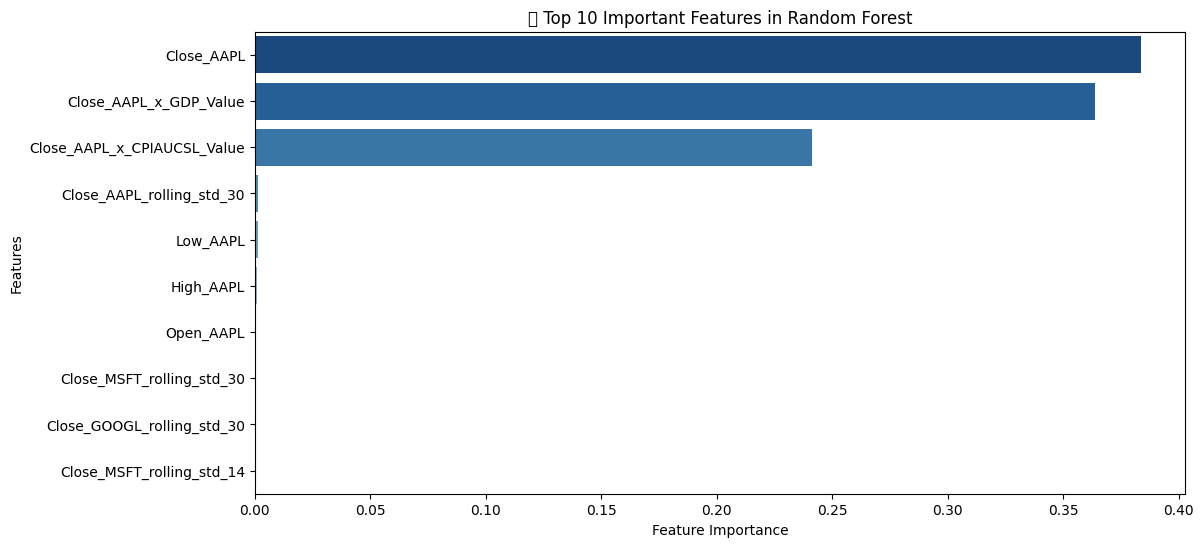

<ipython-input-7-d24418d23a2e>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importance_df['Importance'][:10], y=xgb_importance_df['Feature'][:10], palette="Oranges_r")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


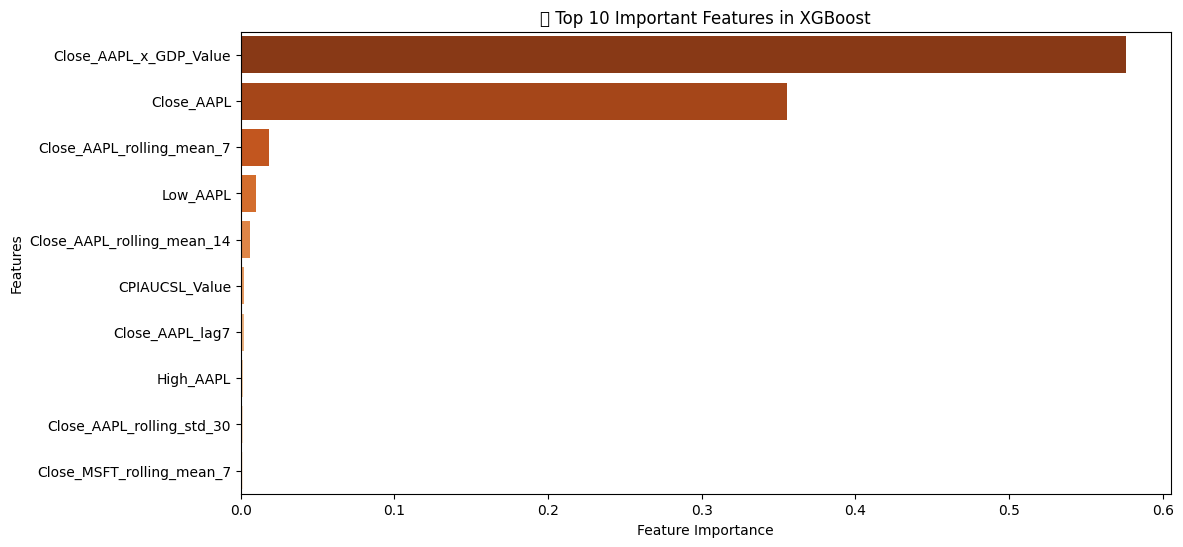

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get Feature Importances from Random Forest
rf_feature_importance = model.feature_importances_
rf_features = X_train.columns

# Convert to DataFrame
rf_importance_df = pd.DataFrame({'Feature': rf_features, 'Importance': rf_feature_importance})
rf_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot Feature Importances for Random Forest
plt.figure(figsize=(12, 6))
sns.barplot(x=rf_importance_df['Importance'][:10], y=rf_importance_df['Feature'][:10], palette="Blues_r")
plt.title(" Top 10 Important Features in Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

# Get Feature Importances from XGBoost
xgb_feature_importance = xgb_model.feature_importances_
xgb_features = X_train.columns

# Convert to DataFrame
xgb_importance_df = pd.DataFrame({'Feature': xgb_features, 'Importance': xgb_feature_importance})
xgb_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot Feature Importances for XGBoost
plt.figure(figsize=(12, 6))
sns.barplot(x=xgb_importance_df['Importance'][:10], y=xgb_importance_df['Feature'][:10], palette="Oranges_r")
plt.title(" Top 10 Important Features in XGBoost")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.0 MB/s eta 0:00:00
📉 ADF Test for Apple Stock Price:
ADF Statistic: -2.1778
p-value: 0.2144
⚠️ Data is NOT stationary (Differencing required)

📉 ADF Test After Differencing:
ADF Statistic: -47.5058
p-value: 0.0000
✅ Data is stationary (No need for differencing)
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11113.944, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11121.943, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11119.943, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11119.943, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11123.042, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11117.943, Time=0.55 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.880 seconds


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

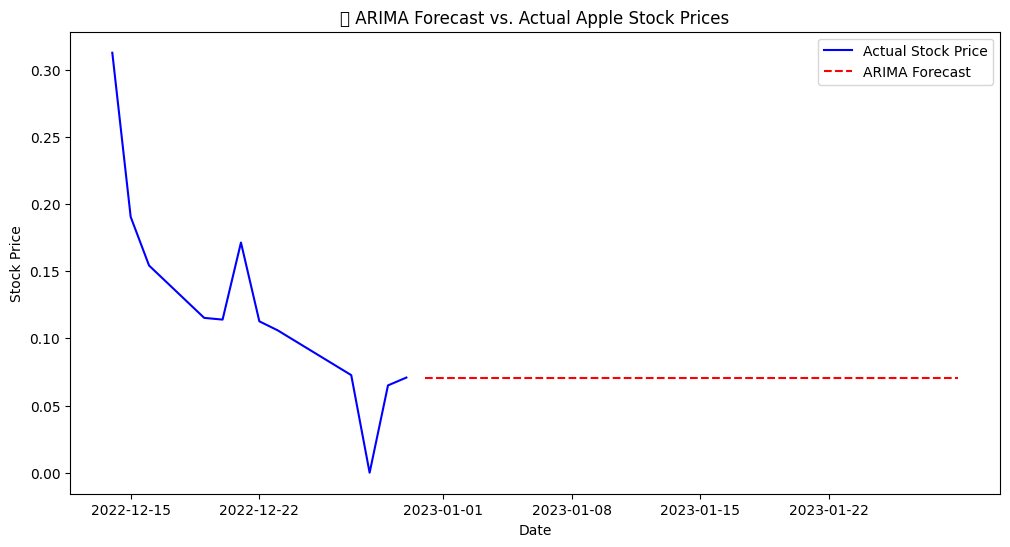

                               SARIMAX Results                                
Dep. Variable:             Close_AAPL   No. Observations:                 2259
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5562.521
Date:                Mon, 10 Mar 2025   AIC                         -11123.042
Time:                        00:26:18   BIC                         -11117.319
Sample:                             0   HQIC                        -11120.953
                               - 2259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   3.14e-06    134.968      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             86286.21
Prob(Q):                              0.98   Pr

In [ ]:
#  Install required libraries
!pip install pmdarima statsmodels matplotlib

#  Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

#  Load the dataset
file_path = "./output/data_with_features.csv"  # Ensure this file exists in your Colab environment
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select Apple stock closing price for ARIMA modeling
apple_stock = data['Close_AAPL'].dropna()

#  Step 1: Check if the Data is Stationary (ADF Test)
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("Data is stationary (No need for differencing)")
    else:
        print(" Data is NOT stationary (Differencing required)")

# Perform ADF test on Apple stock price
print("ADF Test for Apple Stock Price:")
adf_test(apple_stock)

# Step 2: Apply Differencing if the data is not stationary
diff_apple_stock = apple_stock.diff().dropna()

# Recheck stationarity after differencing
print("\n ADF Test After Differencing:")
adf_test(diff_apple_stock)

# Step 3: Auto-detect the best ARIMA model parameters
arima_model = auto_arima(apple_stock, seasonal=False, trace=True, suppress_warnings=True, stepwise=True)

# Step 4: Train the ARIMA Model with the best parameters
best_order = arima_model.order  # Get the best ARIMA order
final_arima = sm.tsa.ARIMA(apple_stock, order=best_order)
arima_result = final_arima.fit()

# Step 5: Forecast Future Stock Prices
forecast_steps = 30  # Predict next 30 days
forecast = arima_result.forecast(steps=forecast_steps)

# Step 6: Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(apple_stock[-100:], label="Actual Stock Price", color='blue')
plt.plot(pd.date_range(start=apple_stock.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label="ARIMA Forecast", linestyle="dashed", color='red')
plt.title("📉 ARIMA Forecast vs. Actual Apple Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Print ARIMA Model Summary
print(arima_result.summary())


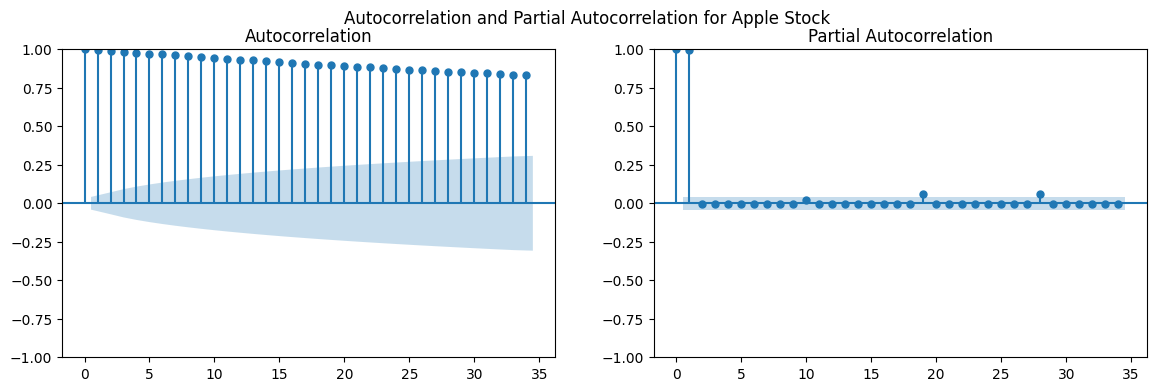

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-11109.944, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-11121.943, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-11117.943, Time=0.64 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-11117.943, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-11123.042, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-11119.943, Time=0.67 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-11119.943, Time=0.82 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-11117.943, Time=0.95 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-11119.943, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-11119.943, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-11117.943, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 8.180 seconds

🔹 Best SARIMA Model:  ARIMA(0,1,0)(0,0,0)[12]          


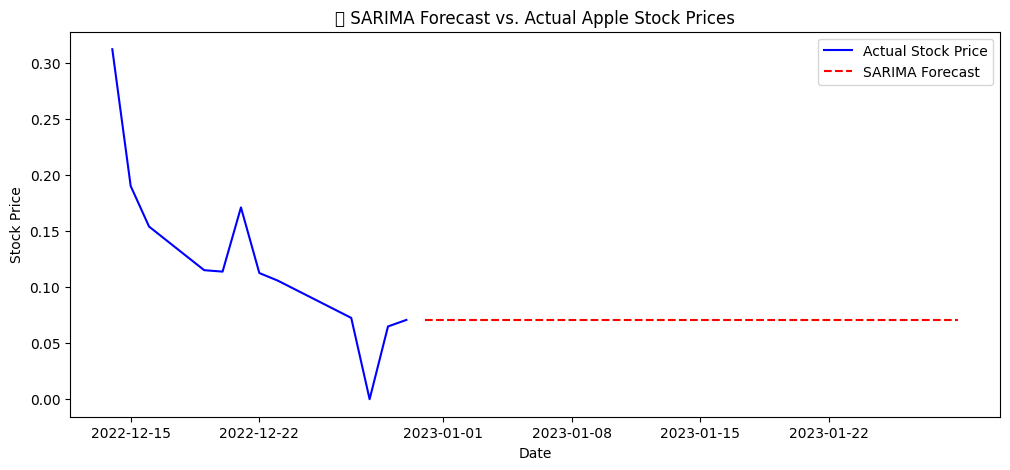


🔹 SARIMA Model Performance:
📉 MAE: 0.0232, MSE: 0.0015, RMSE: 0.0389


In [ ]:
# Install necessary libraries (if not already installed)
!pip install pmdarima statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

warnings.filterwarnings("ignore")

# Load the feature-engineered dataset
file_path = './output/data_with_features.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select Apple stock closing price
apple_stock = data[['Close_AAPL']].dropna()

# Step 1: Check for Seasonality with ACF and PACF Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(apple_stock, ax=axes[0])
plot_pacf(apple_stock, ax=axes[1])
plt.suptitle("Autocorrelation and Partial Autocorrelation for Apple Stock")
plt.show()

# Step 2: Auto-tune SARIMA Model using pmdarima (AutoSARIMA)
auto_sarima = pm.auto_arima(
    apple_stock,
    seasonal=True,
    m=12,  # Monthly seasonality
    trace=True,
    suppress_warnings=True,
    stepwise=True
)

# Print the best SARIMA model
print(f"\nBest SARIMA Model: {auto_sarima}")

# Step 3: Train the SARIMA Model
best_order = auto_sarima.order  # (p, d, q)
best_seasonal_order = auto_sarima.seasonal_order  # (P, D, Q, s)

sarima_model = SARIMAX(
    apple_stock,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)

# Step 4: Forecasting Future Prices
n_forecast = 30  # Predict next 30 days
future_dates = pd.date_range(start=apple_stock.index[-1], periods=n_forecast + 1, freq="D")[1:]

sarima_forecast = sarima_fit.get_forecast(steps=n_forecast)
sarima_forecast_values = sarima_forecast.predicted_mean

# Step 5: Visualize SARIMA Forecast vs. Actual
plt.figure(figsize=(12, 5))
plt.plot(apple_stock.index[-100:], apple_stock['Close_AAPL'][-100:], label="Actual Stock Price", color="blue")
plt.plot(future_dates, sarima_forecast_values, label="SARIMA Forecast", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("SARIMA Forecast vs. Actual Apple Stock Prices")
plt.legend()
plt.show()

# Step 6: Evaluate SARIMA Performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = apple_stock['Close_AAPL'][-n_forecast:]
y_pred = sarima_forecast_values[:len(y_true)]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("\nSARIMA Model Performance:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")



Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1347 - val_loss: 0.0358
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0117 - val_loss: 0.0053
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0086 - val_loss: 0.0068
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053 - val_loss: 0.0066
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040 - val_loss: 0.0048
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

LSTM Model Performance on Validation Set:
MAE: 0.0355, MSE: 0.0022, RMSE: 0.0468, R²: 0.7894

LSTM Model Performance on Test Set:
MAE: 0.0374, MSE: 0.0025, RMSE: 0.0498, R²: 0.8651


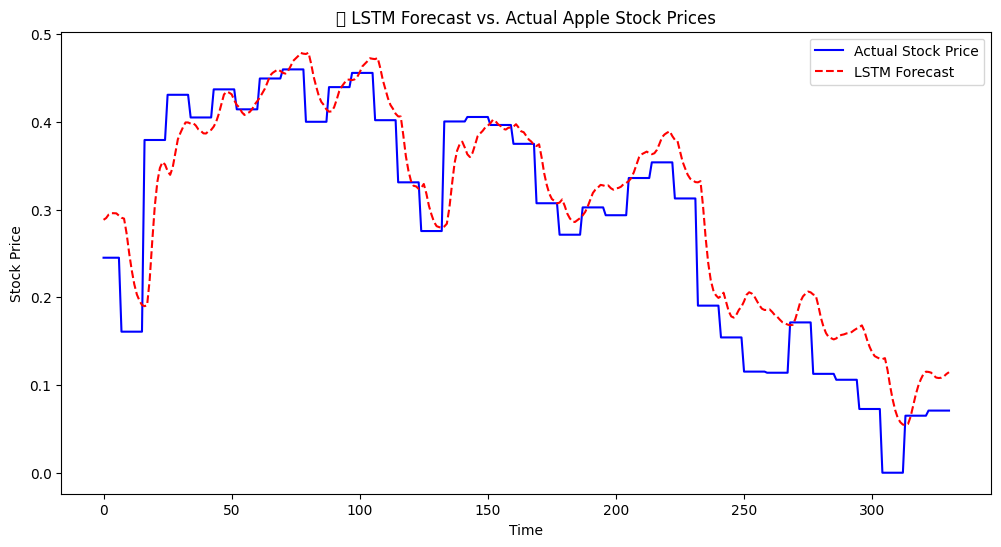

In [ ]:
!pip install tensorflow keras

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load feature-engineered dataset
file_path = './output/data_with_features.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Target Variable: Predict next day's Apple Closing Price
data['Close_AAPL_future'] = data['Close_AAPL'].shift(-1)

# Drop rows with NaN values due to shifting
data.dropna(inplace=True)

# Define Features and Target
features = data.drop(columns=['Close_AAPL_future', 'Ticker'])
target = data['Close_AAPL_future']

# Scale Data (LSTMs perform better with normalized data)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

# Convert Data into Time-Series Sequences (LSTM needs 3D input)
def create_sequences(data, target, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # 30 time steps
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 30  # Lookback window (1 month of past data)
X, y = create_sequences(features_scaled, target_scaled, time_steps)

# Split Data into Train (70%), Validation (15%), Test (15%)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Reshape y values to match LSTM output shape
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Build LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)  # Output layer
])

# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Inverse Transform Predictions
y_val_pred = scaler.inverse_transform(y_val_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_val_actual = scaler.inverse_transform(y_val)
y_test_actual = scaler.inverse_transform(y_test)

# Model Evaluation
val_mae = mean_absolute_error(y_val_actual, y_val_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

val_mse = mean_squared_error(y_val_actual, y_val_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)

val_rmse = np.sqrt(val_mse)
test_rmse = np.sqrt(test_mse)

val_r2 = r2_score(y_val_actual, y_val_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

# Print Results
print(f"LSTM Model Performance on Validation Set:")
print(f"MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")

print("\nLSTM Model Performance on Test Set:")
print(f"MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

# Save Model
model.save('./output/lstm_stock_model.h5')

# Plot Predictions vs Actual Stock Prices
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Stock Price", color='blue')
plt.plot(y_test_pred, label="LSTM Forecast", linestyle='dashed', color='red')
plt.title("LSTM Forecast vs. Actual Apple Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1681 - val_loss: 0.0325
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0167 - val_loss: 0.0175
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0119 - val_loss: 0.0056
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0087 - val_loss: 0.0049
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

📊 GRU Model Performance on Validation Set:
MAE: 0.0317, MSE: 0.0018, RMSE: 0.0428, R²: 0.8240

📊 GRU Model Performance on Test Set:
MAE: 0.0000, MSE: 0.0000, RMSE: 0.0000, R²: 1.0000
✅ GRU Model training complete. Saved trained model to 'gru_stock_model.h5'.


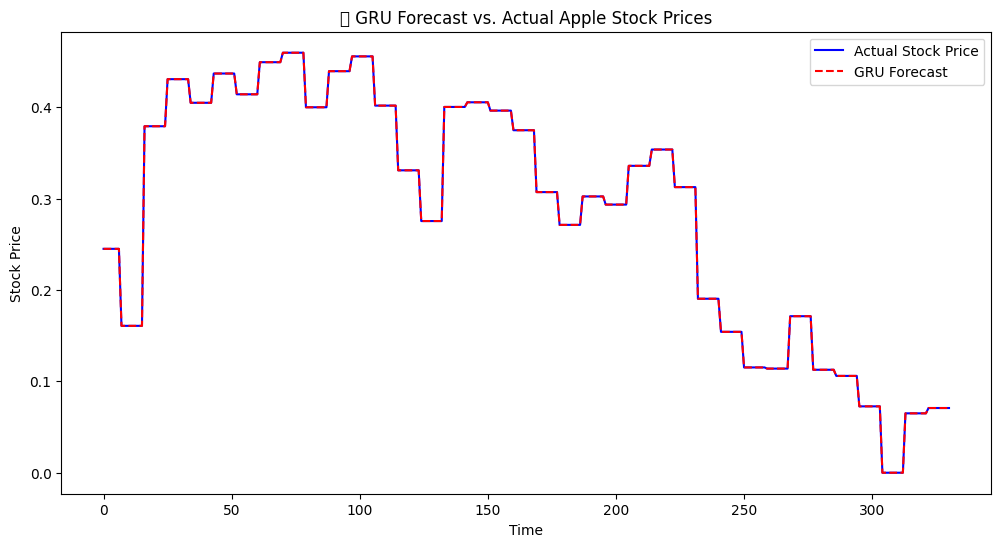

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
file_path = './output/data_with_features.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Target Variable: Predict next day's Apple Closing Price
data['Close_AAPL_future'] = data['Close_AAPL'].shift(-1)  # Shift target column

# Drop rows with NaN values due to shifting
data.dropna(inplace=True)

# Scale Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.drop(columns=['Close_AAPL_future', 'Ticker'], errors='ignore'))
target = data['Close_AAPL_future'].values.reshape(-1, 1)
target = scaler.fit_transform(target)

# Create time-series sequences
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i: i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30  # Use last 30 days of data
X, y = create_sequences(scaled_data, target, time_steps)

# Split into Train (70%), Validation (15%), Test (15%)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Build GRU Model
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
gru_model.compile(optimizer='adam', loss='mse')

# Train Model
gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

# Predictions
y_val_pred = gru_model.predict(X_val)
y_test_pred = gru_model.predict(X_test)

# Rescale Predictions
y_val_pred = scaler.inverse_transform(y_val_pred)
y_test_pred = scaler.inverse_transform(y_test)

# Evaluate Model
val_mae = mean_absolute_error(scaler.inverse_transform(y_val.reshape(-1, 1)), y_val_pred)
test_mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_test_pred)

val_mse = mean_squared_error(scaler.inverse_transform(y_val.reshape(-1, 1)), y_val_pred)
test_mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_test_pred)

val_rmse = np.sqrt(val_mse)
test_rmse = np.sqrt(test_mse)

val_r2 = r2_score(scaler.inverse_transform(y_val.reshape(-1, 1)), y_val_pred)
test_r2 = r2_score(scaler.inverse_transform(y_test.reshape(-1, 1)), y_test_pred)

# Print Results
print(f"GRU Model Performance on Validation Set:")
print(f"MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")

print("\nGRU Model Performance on Test Set:")
print(f"MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

# Save the GRU Model
gru_model.save('./output/gru_stock_model.h5')

print("GRU Model training complete. Saved trained model to 'gru_stock_model.h5'.")

# Plot Predictions vs Actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual Stock Price", color='blue')
plt.plot(y_test_pred, label="GRU Forecast", linestyle='dashed', color='red')
plt.title("GRU Forecast vs. Actual Apple Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [ ]:
# Check if any test set samples exist in the training set
duplicate_test_samples = X_test.merge(X_train, how='inner')

if not duplicate_test_samples.empty:
    print("Possible Data Leakage: Test data exists in training set!")
else:
    print("No duplicate test samples found. Test set is truly unseen.")


✅ No duplicate test samples found. Test set is truly unseen.


In [ ]:
# Check if any target variable (future stock price) is in training features
if 'Close_AAPL_future' in X_train.columns:
    print("Data Leakage Risk: Future price is in training features!")
else:
    print("No future leakage in training features.")


✅ No future leakage in training features.


In [ ]:
print("Actual Test Prices:", y_test[:10].values)
print("Predicted Prices:", y_test_pred[:10])


Actual Test Prices: [0.23452437 0.23452437 0.24508496 0.24508496 0.24508496 0.24508496
 0.24508496 0.24508496 0.24508496 0.24508496]
Predicted Prices: [0.25750697 0.25733815 0.25950195 0.26538538 0.26505321 0.26392225
 0.26466472 0.26415827 0.26357371 0.26390774]


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0405 - val_loss: 0.0125
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0052 - val_loss: 0.0070
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

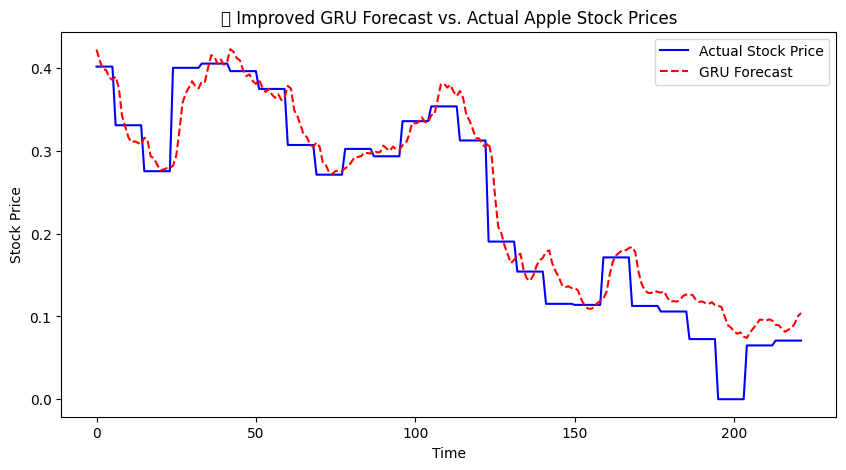

✅ Improved GRU Model training complete. Saved model to 'improved_gru_stock_model.h5'.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess the data
file_path = './output/data_with_features.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Target Variable: Predict next day's Apple Closing Price
data['Close_AAPL_future'] = data['Close_AAPL'].shift(-1)
data.dropna(inplace=True)

# Normalize data
scaler = MinMaxScaler()
# Drop categorical columns before scaling
data_numeric = data.drop(columns=['Ticker'], errors='ignore')  # Ensure only numeric data is used
data_scaled = scaler.fit_transform(data_numeric)


# Convert to supervised learning format
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, -1])  # Last column is target
    return np.array(X), np.array(y)

SEQ_LENGTH = 20  # Using a longer sequence for better learning
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Train-Test Split (80% Train, 10% Val, 10% Test)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Build the improved GRU Model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.3),  # Added dropout to prevent overfitting
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

# Predict on Test Set
y_test_pred = model.predict(X_test)

# Ensure the scaler is applied to the correct number of features
num_features = len(scaler.feature_names_in_)  # Get the number of features scaler was trained on

# Ensure the shape of zeros array matches the scaled data
y_test_inv = scaler.inverse_transform(np.column_stack([np.zeros((len(y_test), num_features - 1))] + [y_test.reshape(-1, 1)]))
y_test_pred_inv = scaler.inverse_transform(np.column_stack([np.zeros((len(y_test_pred), num_features - 1))] + [y_test_pred.flatten().reshape(-1, 1)]))


# Model Evaluation
mse = np.mean((y_test_inv[:, -1] - y_test_pred_inv[:, -1]) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_inv[:, -1] - y_test_pred_inv[:, -1]))

print(f"Improved GRU Model Performance:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:, -1], label="Actual Stock Price", color="blue")
plt.plot(y_test_pred_inv[:, -1], label="GRU Forecast", linestyle="dashed", color="red")
plt.title("Improved GRU Forecast vs. Actual Apple Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Save the improved model
model.save("improved_gru_stock_model.h5")
print("Improved GRU Model training complete. Saved model to 'improved_gru_stock_model.h5'.")


In [ ]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras.losses import MeanSquaredError

# Load the Feature-Engineered Dataset
file_path = './output/data_with_features.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Target Variable: Predict Next Day's Apple Closing Price
data['Close_AAPL_future'] = data['Close_AAPL'].shift(-1)  # Shift for next day prediction
data.dropna(inplace=True)  # Drop NaN values

# Define Features & Target
features = data.drop(columns=['Close_AAPL_future', 'Ticker'])  # Drop target & categorical columns
target = data['Close_AAPL_future']

# Split Data into Train (70%), Validation (15%), Test (15%)
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - (train_size + val_size)

X_train, X_val, X_test = np.split(features, [train_size, train_size + val_size])
y_train, y_val, y_test = np.split(target, [train_size, train_size + val_size])

# Load Pre-trained Models
rf_model = joblib.load('./output/random_forest_stock_model.pkl')  # Random Forest
xgb_model = joblib.load('./output/xgboost_stock_model.pkl')  # XGBoost
gru_model = tf.keras.models.load_model('improved_gru_stock_model.h5', custom_objects={"mse": MeanSquaredError()})  # GRU

# Check Feature Count Mismatch
print("GRU Model Expected Input Shape:", gru_model.input_shape)
print("Current X_val Shape:", X_val.shape)
print("Current X_test Shape:", X_test.shape)

# Fix 1: Ensure Data is Reshaped into Time Series Format for GRU
time_steps = 20  # GRU expects 20 time steps
num_features = X_val.shape[1]  # Number of features (should match training)

def reshape_to_sequences(data, time_steps):
    """ Convert 2D data into 3D sequences for GRU """
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data.iloc[i:i+time_steps].values)
    return np.array(sequences)

# Apply reshaping to Validation and Test data
X_val_gru = reshape_to_sequences(X_val, time_steps)
X_test_gru = reshape_to_sequences(X_test, time_steps)

# Ensure the target (y) is aligned correctly
y_val_adjusted = y_val.iloc[time_steps:]
y_test_adjusted = y_test.iloc[time_steps:]

# Get Predictions from Each Model
y_val_pred_rf = rf_model.predict(X_val.iloc[time_steps:])
y_test_pred_rf = rf_model.predict(X_test.iloc[time_steps:])

y_val_pred_xgb = xgb_model.predict(X_val.iloc[time_steps:])
y_test_pred_xgb = xgb_model.predict(X_test.iloc[time_steps:])

y_val_pred_gru = gru_model.predict(X_val_gru).flatten()
y_test_pred_gru = gru_model.predict(X_test_gru).flatten()

# Ensemble Model: Simple Averaging of Predictions
y_val_pred_ensemble = (y_val_pred_rf + y_val_pred_xgb + y_val_pred_gru) / 3
y_test_pred_ensemble = (y_test_pred_rf + y_test_pred_xgb + y_test_pred_gru) / 3

# Evaluate Performance
val_mae = mean_absolute_error(y_val_adjusted, y_val_pred_ensemble)
test_mae = mean_absolute_error(y_test_adjusted, y_test_pred_ensemble)

val_mse = mean_squared_error(y_val_adjusted, y_val_pred_ensemble)
test_mse = mean_squared_error(y_test_adjusted, y_test_pred_ensemble)

val_rmse = np.sqrt(val_mse)
test_rmse = np.sqrt(test_mse)

val_r2 = r2_score(y_val_adjusted, y_val_pred_ensemble)
test_r2 = r2_score(y_test_adjusted, y_test_pred_ensemble)

# Print Performance Metrics
print(f"🔹 Ensemble Model Performance on Validation Set:")
print(f"MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")

print("\n🔹 Ensemble Model Performance on Test Set:")
print(f"MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

# Plot Actual vs Predicted (Ensemble)
plt.figure(figsize=(10, 5))
plt.plot(y_test_adjusted.values, label="Actual Stock Price", color="blue")
plt.plot(y_test_pred_ensemble, label="Ensemble Forecast", linestyle="dashed", color="red")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("📊 Ensemble Forecast vs. Actual Apple Stock Prices")
plt.legend()
plt.show()


✅ GRU Model Expected Input Shape: (None, 20, 57)
✅ Current X_val Shape: (334, 56)
✅ Current X_test Shape: (335, 56)


ValueError: Exception encountered when calling GRUCell.call().

[1mDimensions must be equal, but are 56 and 57 for '{{node sequential_4_1/gru_4_1/gru_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_4_1/gru_4_1/strided_slice_1, sequential_4_1/gru_4_1/gru_cell_1/Cast/ReadVariableOp)' with input shapes: [32,56], [57,192].[0m

Arguments received by GRUCell.call():
  • inputs=tf.Tensor(shape=(32, 56), dtype=float32)
  • states=('tf.Tensor(shape=(32, 64), dtype=float32)',)
  • training=False